# CoAtNet for Segmentation (Cityscapes)

# Imports

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !pip install einops

In [2]:
import os
import time
import PIL
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets
from tqdm.notebook import tqdm
from einops import rearrange
from einops.layers.torch import Rearrange
from torch.optim.lr_scheduler import ReduceLROnPlateau


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

print(device)

cuda


In [3]:
# root_path = './drive/MyDrive/cityscapes_data'
root_path = './cityscapes_data'
data_dir = root_path
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)

# Dataset

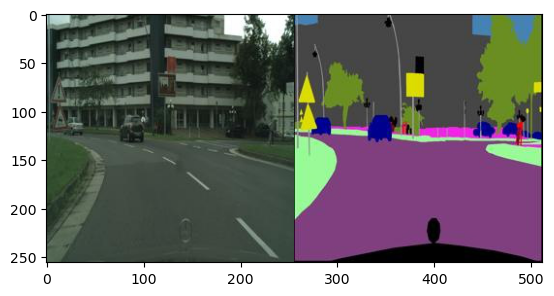

In [4]:
sample_image_fp = os.path.join(train_dir, train_fns[0])

sample_image = Image.open(sample_image_fp).convert("RGB")

plt.imshow(sample_image)
plt.show()

In [5]:
color_array = np.array([(0, 0, 0), (0, 0, 70), (0, 0, 90), (0, 0, 110), (0, 0, 142), (0, 0, 230), (0, 60, 100), (0, 80, 100), (70, 70, 70), (70, 130, 180), (81, 0, 81), (102, 102, 156), (107, 142, 35), (111, 74, 0), (119, 11, 32), (128, 64, 128), (150, 100, 100), (150, 120, 90), (152, 251, 152), (153, 153, 153), (180, 165, 180), (190, 153, 153), (220, 20, 60), (220, 220, 0), (230, 150, 140), (244, 35, 232), (250, 170, 30), (250, 170, 160), (255, 0, 0)])
num_classes = 29
label_model = KMeans(n_clusters = num_classes)
label_model.fit(color_array)

KMeans(n_clusters=29)

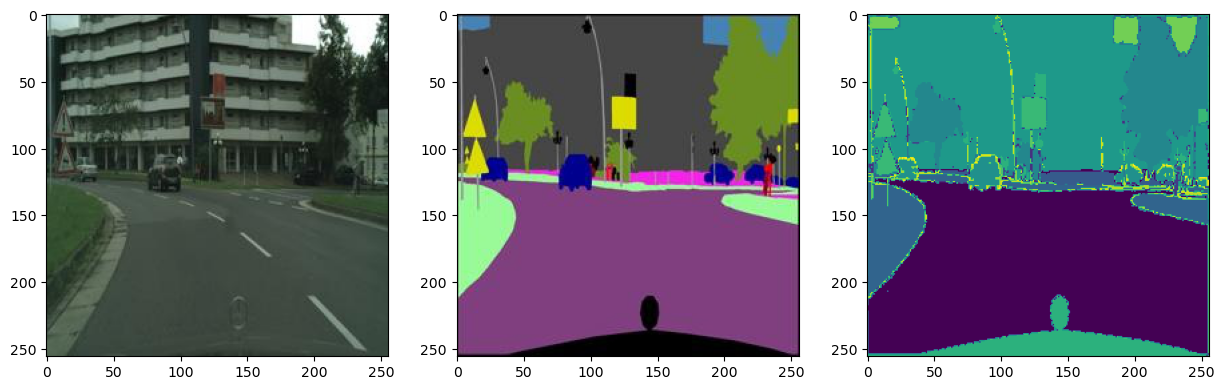

In [6]:
# 이전에 샘플이미지에서 볼 수 있듯이, original image와 labeled image가 연결되어 있는데 이를 분리해줍니다.
def split_image(image) :
   image = np.array(image)
   
   # 이미지의 크기가 256 x 512 였는데 이를 original image와 labeled image로 분리하기 위해 리스트로 슬라이싱 합니다.
   # 그리고 분리된 이미지를 각각 cityscape(= original image)와 label(= labeled image)에 저장합니다.
   cityscape, label = image[:, :256, :], image[:, 256:, :]
   return cityscape, label


# 바로 이전 코드에서 정의한 split_image() 함수를 이용하여 sample_image를 분리한 후, cityscape과 label에 각각 저장합니다.
cityscape, label = split_image(sample_image)

label_class = label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)
axes[2].imshow(label_class)

plt.show()

In [7]:
class CityscapeDataset(Dataset):

  def __init__(self, image_dir, label_model):
    self.image_dir = image_dir
    self.image_fns = os.listdir(image_dir)
    self.label_model = label_model
    
  def __len__(self) :
    return len(self.image_fns)
    
  def __getitem__(self, index) :
    image_fn = self.image_fns[index]
    image_fp = os.path.join(self.image_dir, image_fn)
    image = Image.open(image_fp)
    image = np.array(image)
    cityscape, label = self.split_image(image)
    label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(256, 256)
    label_class = torch.Tensor(label_class).long()
    cityscape = self.transform(cityscape)
    return cityscape, label_class
    
  def split_image(self, image) :
    image = np.array(image)
    cityscape, label = image[ : , :256, : ], image[ : , 256: , : ]
    return cityscape, label
    
  def transform(self, image) :
    transform_ops = transforms.Compose([
      			        transforms.ToTensor(),
                    transforms.Normalize(mean = (0.485, 0.56, 0.406), std = (0.229, 0.224, 0.225))
    ])
    return transform_ops(image)

In [8]:
dataset = CityscapeDataset(train_dir, label_model)
print(len(dataset))

cityscape, label_class = dataset[0]
print(cityscape.shape)
print(label_class.shape)

2975
torch.Size([3, 256, 256])
torch.Size([256, 256])


# Training

### Parameters

In [9]:
from unet_model import UNet
from coatunet_model import CoAtUNet

model_type = "unet"        #{"unet","coatunet"}
batch_size = 16 # tuning
epochs = 20 # tuning
lr = 1e-2 # tuning

if model_type == "unet":
    #UNet
    model = UNet(n_channels=3, n_classes=29).to(device)
    model_path = "./models/" + "UNet_{}.pth".format(epochs)
elif model_type == "coatunet" :
    #CoAtUNet
    model = CoAtUNet(
        image_size=(256, 256), 
        in_channels=3, 
        num_blocks=[2, 2, 3, 5, 2], # tuning
        channels=[24, 48, 96, 192, 384, 768, 1536], # tuning
        num_classes=29,
        block_types=['C', 'C', 'T', 'T'] # tuning
        ).to(device)
    model_path = "./models/" + "CoAtUNet_{}.pth".format(epochs)

#model.to(device)

In [10]:
dataset = CityscapeDataset(train_dir, label_model)
data_loader = DataLoader(dataset, batch_size = batch_size)

# 손실함수 정의
criterion = nn.CrossEntropyLoss()
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), lr = lr)
#scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2)


step_losses = []
epoch_losses = []

for epoch in tqdm(range(epochs)) :
  epoch_loss = 0

  for X, Y in tqdm(data_loader, total = len(data_loader), leave = False) :
    X, Y = X.to(device), Y.to(device)
    optimizer.zero_grad()
    Y_pred = model(X)
    # print('X: ', X.shape)
    # print('Y: ', Y.shape)
    # print('Y_pred: ', Y_pred.shape)
    loss = criterion(Y_pred, Y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    step_losses.append(loss.item())
  epoch_losses.append(epoch_loss/len(data_loader))


torch.save({
  'model' : model.state_dict(),
  },model_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

  0%|          | 0/186 [00:00<?, ?it/s]

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(step_losses)
axes[1].plot(epoch_losses)

plt.show()

### Load Checkpoint

In [ ]:
# chk = torch.load(model_path)
# model.load_state_dict(chk['model'])

# Results

### Show Samples

In [ ]:
test_print_size = 5
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size = test_print_size)

X,Y = next(iter(data_loader))
X,Y = X.to(device), Y.to(device)
Y_pred = model(X)
Y_pred = torch.argmax(Y_pred, dim=1)

inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

fig, axes = plt.subplots(test_print_size, 3, figsize=(3*5, test_print_size*5))

for i in range(test_print_size):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")

plt.show()

### Evaluation

In [ ]:
def miou(actual, predict, num_classes):
  categories = num_classes * actual + predict
  categories_bins = np.bincount(categories.reshape(-1), minlength=num_classes**2)
  categories_reshape = categories_bins.reshape(num_classes,num_classes)
  categories_sum0 = categories_reshape.sum(axis=0)
  categories_sum1 = categories_reshape.sum(axis=1)
  intersection = []
  union = []
  for class_num in range(num_classes):
    i = categories_reshape[class_num,class_num]
    u = categories_sum0[class_num] + categories_sum1[class_num] - i
    if (u != 0):
      intersection.append(i)
      union.append(u)
  iou = np.array(intersection) / np.array(union)
  m = np.mean(iou)
  return m

In [ ]:
from sklearn.metrics import jaccard_score

test_batch_size = 16
dataset = CityscapeDataset(val_dir, label_model)
data_loader = DataLoader(dataset, batch_size = test_batch_size)

acc_scores = []
jac_scores = []
img_size = 256 * 256

model.eval()
with torch.no_grad() :
  for X, Y in tqdm(data_loader, total = len(data_loader), leave = False) :
    X, Y = X.to(device), Y.to(device)
    Y_pred = model(X)
    Y_pred = torch.argmax(Y_pred, dim=1)
    for i in range(Y.shape[0]):
      label_class = Y[i].cpu().detach().numpy()
      label_class_predicted = Y_pred[i].cpu().detach().numpy()

      #Accuracy (raw)
      acc_score = np.sum(label_class == label_class_predicted) / img_size
      acc_scores.append(acc_score)

      #Jaccard Score (Macro)
      jac_score = jaccard_score(label_class.flatten(), label_class_predicted.flatten(), average='macro')
      jac_scores.append(jac_score)

### Evaluation : Accuracy, MioU-Score

In [ ]:
print("Mean Accuracy : {:.3f}".format(np.mean(acc_scores)))
#print("MioU Score : {:.3f}".format(np.mean(miou_scores)))
print("Jaccard Score (Macro) : {:.3f}".format(np.mean(jac_scores)))